In [1]:
%pylab inline
import numpy as np
import pandas as pd
import cv2
import os
import glob
import logging
logging.basicConfig(level=logging.DEBUG)
# import psutil
# mem = psutil.virtual_memory()
# print('Total memory: {:d}'.format(mem.total))
# import tifffile
import math
import csv
import dataset


Populating the interactive namespace from numpy and matplotlib


The following code is responsible for loading the images from storage and resizing and scaling.
The data, being greater than 2 TB in size, would not fit on one hard drive and had to be split upon two disks.

In [2]:
!gksu "mount /mnt/images1 && mount /mnt/images2"

Gkr-Message: secret service operation failed: The name org.freedesktop.secrets was not provided by any .service files

(gksu:7683): Gtk-WARNING **: Failed to set text from markup due to error parsing markup: Error on line 3: Entity did not end with a semicolon; most likely you used an ampersand character without intending to start an entity - escape ampersand as &amp;

(gksu:7683): Gtk-WARNING **: Failed to set text from markup due to error parsing markup: Error on line 3: Entity did not end with a semicolon; most likely you used an ampersand character without intending to start an entity - escape ampersand as &amp;
Gkr-Message: secret service operation failed: The name org.freedesktop.secrets was not provided by any .service files
Gkr-Message: secret service operation failed: The name org.freedesktop.secrets was not provided by any .service files
_TIME0
gksu-run: dc27fe9d770daa953e9c9d11b9a55a60

mount: /dev/sdc1 is already mounted or /mnt/images1 busy
       /dev/sdc1 is already moun

In [3]:
def path(feature):
    # Find file on storage device
    if os.path.isfile(feature):
        fd = feature
    elif os.path.isfile('/media/connor/sdc/{0}.tif'.format(feature)):
        fd = '/media/connor/sdc/{0}.tif'.format(feature)
    elif os.path.isfile('/media/connor/sdd/{0}.tif'.format(feature)):
        fd = '/media/connor/sdd/{0}.tif'.format(feature)
    else:
        logging.warning('Cannot find file for image {}.'.format(feature))
        return None
    
    return fd

In [3]:
def search_file(filename, search_path):
    """Given a search path, find file
   """
    file_found = 0
    paths = search_path.split(os.pathsep)
    for path in paths:
        if os.path.exists(os.path.join(path, filename)):
            file_found = 1
            break
    if file_found:
        return os.path.abspath(os.path.join(path, filename))
    else:
        print(f"FAILED TO FIND {filename} IN {search_path}!", file=sys.stderr)
        return None

Load patient status from PLCO CSV files and find associated filenames

In [12]:
cancer_ids = []
healthy_ids = []
cancer_images = []
healthy_images = []

with open('/home/connor/Documents/PLCO/all_4_datasets/plco234_person_feb16_101016.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Log the unique PLCO id of individuals diagnosed with lung cancer.
        #  This ID number can be associated with multiple images.
        if int(row['confirmed_lung']) == 1:
            cancer_ids.append(row['plco_id'])
        if int(row['cstatusl_cat']) == 1:
            cancer_ids.append(row['plco_id'])

linked = 0
i = 0
with open('/home/connor/Documents/PLCO/all_4_datasets/plco234_image_feb16_101016.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    link_type = [1, 2, 3, 4]
    for row in reader:
        # Add images that were positively linked to a cancer diagnosis within 30 days.
        if row['plco_id'] in cancer_ids:
            if int(row['link_type']) in link_type:
                cancer_images.append((row['filename'], row['image_file_center']))
                linked += 1
        # Add other images to the healthy images class. As there are more healthy images than
        #  cancerous images in this dataset, this is restricted to equalize the length of the sets.
        if row['linked_result'] == str(1) and i < 4378:
            healthy_images.append((row['filename'], row['image_file_center']))
            i += 1

    
print("Healthy: {0}, cancer: {1}".format(len(healthy_images), len(cancer_images)))
for i, center in [(1, 'cu'), (2, 'gt'), (3, 'hawaii'), (4, 'ford'), (5, 'mn'), (6, 'washu'), (7, 'penn'), (8, 'mf'), (9, 'uab')]:
    healthy = [fn for fn, cn in healthy_images if int(cn) == i]
    cancer = [fn for fn, cn in cancer_images if int(cn) == i]
    print(cancer)
    thealthy = int(sum(healthy))
    tcancer = int(sum(cancer))
    total = int(thealthy + tcancer)
    print(f"{center} \t {thealthy:4d} {tcancer:4d} {total:4d}")

Healthy: 4378, cancer: 4378
['AC04360091007130604_v2', 'AC04360091007131549_v2', 'AC04360091007131654_v2', 'AC04360091007131753_v2', 'AB06720081907180433_v2', 'AB06720081907180526_v2', 'AB06720081907180634_v2', 'AB06720081907180726_v2', 'AB06720081907180829_v2', 'AD04383090707144237_v2', 'AC03302090707121513_v2', 'AC03302090707121610_v2', 'AC03302090707121700_v2', 'AC03302090707121754_v2', 'AG04884081507145914_v2', 'AG04884081507150008_v2', 'AA04878081707110047_v2', 'AA04878081707110157_v2', 'AA04878081707110312_v2', 'AA04878081707110406_v2', 'AC04542081907194541_v2', 'AC04542081907194653_v2', 'AC03304081707180609_v2', 'AI00332081907133359_v2', 'AI00332081907133506_v2', 'AI00332081907133618_v2', 'AI00332081907133740_v2', 'AJ05195082907105031_v2', 'AJ05195082907105146_v2', 'AJ05195082907105240_v2', 'AJ05195082907105414_v2', 'AB06410090407122435_v2', 'AB06410090407122528_v2', 'AB06410090407122613_v2', 'AB06410090407122716_v2', 'AD01382082307091944_v2', 'AD01382082307092052_v2', 'AD013820

TypeError: cannot perform reduce with flexible type

In [4]:
plcoperson = pd.read_csv('../all_4_datasets/plco234_person_feb16_101016.csv')
plcoimage = pd.read_csv('../all_4_datasets/plco234_image_feb16_101016.csv')
plcodata = plcoimage.merge(plcoperson, on='plco_id')

In [5]:
cancer_rows = plcodata[plcodata.confirmed_lung==1][plcodata.link_type>0][plcodata.link_type<5]
healthy_rows = plcodata[plcodata.linked_result==1][:len(cancer_rows)]
print(f"Healthy: {len(healthy_rows):4d} Cancer: {len(cancer_rows):4d}")

Healthy: 4378 Cancer: 4378


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [6]:
for i, center in [(1, 'cu'), (2, 'gt'), (3, 'hawaii'), (4, 'ford'), (5, 'mn'), (6, 'washu'), (8, 'penn'), (10, 'mf'), (11, 'uab')]:
    thealthy = len(healthy_rows[healthy_rows.image_file_center == float(i)])
    tcancer = len(cancer_rows[cancer_rows.image_file_center == float(i)])
    total = int(thealthy + tcancer)
    print(f"{center} \t {thealthy:4d} {tcancer:4d} {total:4d}")

cu 	    0  266  266
gt 	    1  274  275
hawaii 	    0  304  304
ford 	    3  695  698
mn 	    0 1163 1163
washu 	    0  510  510
penn 	    0  714  714
mf 	 4374  255 4629
uab 	    0  197  197


In [9]:
train = dataset.Dataset('PLCO_train', (256, 256), ['negative', 'cancer'], max_memory = 5 * (10**9), test_size=0)
test = dataset.Dataset('PLCO_test', (256, 256), ['negative', 'cancer'], max_memory = 5 * (10**9), test_size=1)

for index, row in cancer_rows.iterrows():
    filename = search_file(row.filename + '.tif', '/mnt/images1:/mnt/images2')
    if row.image_file_center == 5:
        test.add_feature(filename, 'cancer')
    else:
        train.add_feature(filename, 'cancer')
i = 0
for index, row in healthy_rows.iterrows():
    filename = search_file(row.filename + '.tif', '/mnt/images1:/mnt/images2')
    if i < 3283:
        train.add_feature(filename, 'negative')
    else:
        test.add_feature(filename, 'negative')
    i+=1
    
train.save()
test.save()

INFO:dataset:Initialized dataset with 9536 features.
INFO:dataset:Initialized dataset with 9536 features.
INFO:dataset:Added feature 100.
INFO:dataset:Added feature 200.
INFO:dataset:Added feature 300.
INFO:dataset:Added feature 400.
INFO:dataset:Added feature 500.
INFO:dataset:Added feature 600.
INFO:dataset:Added feature 700.
INFO:dataset:Added feature 800.
INFO:dataset:Added feature 900.
INFO:dataset:Added feature 1000.
INFO:dataset:Added feature 1100.
INFO:dataset:Added feature 1200.
INFO:dataset:Added feature 1300.
INFO:dataset:Added feature 1400.
INFO:dataset:Added feature 1500.
INFO:dataset:Added feature 1600.
INFO:dataset:Added feature 1700.
INFO:dataset:Added feature 100.
INFO:dataset:Added feature 200.
INFO:dataset:Added feature 300.
INFO:dataset:Added feature 400.
INFO:dataset:Added feature 500.
INFO:dataset:Added feature 600.
INFO:dataset:Added feature 700.
INFO:dataset:Added feature 800.
INFO:dataset:Added feature 900.
INFO:dataset:Added feature 1000.
INFO:dataset:Added fe

The following cells present an example visualization of the dataset.

In [7]:
data.features[0].reshape((256, 256))

array([[ 0.05871672,  0.05871672,  0.05871672, ...,  0.05871672,
         0.05871672,  0.05871672],
       [ 0.05871672,  0.05871672,  0.05812161, ...,  0.05819791,
         0.05871672,  0.05871672],
       [ 0.05871672,  0.05813687,  0.05822843, ...,  0.0582742 ,
         0.05822843,  0.05819791],
       ..., 
       [ 0.05871672,  0.05796902,  0.05821317, ...,  0.05807584,
         0.05807584,  0.05871672],
       [ 0.05871672,  0.05871672,  0.05857939, ...,  0.05813687,
         0.05871672,  0.05871672],
       [ 0.05871672,  0.05871672,  0.05871672, ...,  0.05871672,
         0.05871672,  0.05871672]])

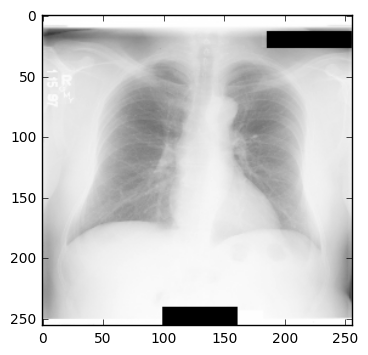

In [8]:
imshow(_, cmap=cm.gray)